In [1]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
sns.set()

In [37]:
client = bigquery.Client()

query="""
SELECT * from goldenfleece.final_task.monthly_gdp order by DATE
"""
gdp_df = client.query(query).to_dataframe()
gdp_df.head()

,DATE,GDP
0,1997-06-01,0.8
1,1997-07-01,0.1
2,1997-08-01,0.4
3,1997-09-01,0.5
4,1997-10-01,0.8


In [38]:
gdp_df = gdp_df.astype({"DATE":"datetime64"}).set_index("DATE") 
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 280 entries, 1997-06-01 to 2020-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     280 non-null    float64
dtypes: float64(1)
memory usage: 4.4 KB


In [39]:
def pre_process(df, start_date, end_date):
    df = df.copy()
    df["GDP_lag1"] = df["GDP"].shift()
    return df.loc[start_date:end_date]

processed_gdp_df = pre_process(gdp_df, start_date="2009-01-01", end_date="2020-09-01")
processed_gdp_df.head()

,GDP,GDP_lag1
DATE,,
2009-01-01,-2.0,-2.1
2009-02-01,-1.5,-2.0
2009-03-01,-1.6,-1.5
2009-04-01,-1.1,-1.6
2009-05-01,-1.0,-1.1


In [41]:
X = processed_gdp_df[["GDP_lag1"]]
y = processed_gdp_df["GDP"]

We will make a one-step forecast (horizon=1 month) with the AR(1) model

In [45]:
from sklearn.model_selection import TimeSeriesSplit

# test size will be n_samples//(n_splits + 1)
# to ensure maximum n_splits with a test size of 1, we set n_splits to be n_samples//2 
n_splits = len(X)//2
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(X):
    assert len(test_index) == 1

In [43]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

scores = cross_validate(lr, X, y, scoring='neg_root_mean_squared_error', cv=tscv, return_estimator=True)

Calculate the average RMSE over 70 predictions

In [73]:
scores_df = pd.DataFrame(scores)
processed_gdp_df_test = processed_gdp_df.iloc[n_splits+1:].reset_index()
merged_df = scores_df.merge(processed_gdp_df_test, left_index=True, right_index=True)
assert len(scores_df) == len(processed_gdp_df_test) == len(merged_df)
merged_df["test_score"] = merged_df["test_score"].multiply(-1)

merged_df.head()

,fit_time,score_time,estimator,test_score,DATE,GDP,GDP_lag1
0,0.003389,0.001763,LinearRegression(),0.015169,2014-12-01,0.6,0.6
1,0.002889,0.001849,LinearRegression(),0.085072,2015-01-01,0.5,0.6
2,0.002530,0.001576,LinearRegression(),0.103463,2015-02-01,0.4,0.5
3,0.002605,0.001782,LinearRegression(),0.021760,2015-03-01,0.4,0.4
4,0.003577,0.001599,LinearRegression(),0.178532,2015-04-01,0.6,0.4


In [62]:
rmse = merged_df["test_score"]
print(f"Average RMSE over {len(rmse)} predictions: {rmse.mean():.3f}")

Average RMSE over 70 predictions: 1.053


In [79]:
import numpy as np

predicted_list = []
for estimator, lag in zip(merged_df["estimator"], merged_df["GDP_lag1"]):
    predicted = estimator.predict(np.array([[lag]]))
    # sklearn predict will return a numpy array so need to index it
    predicted_list.append(predicted[0])

merged_df["predicted_GDP"] = predicted_list

<AxesSubplot:xlabel='DATE'>

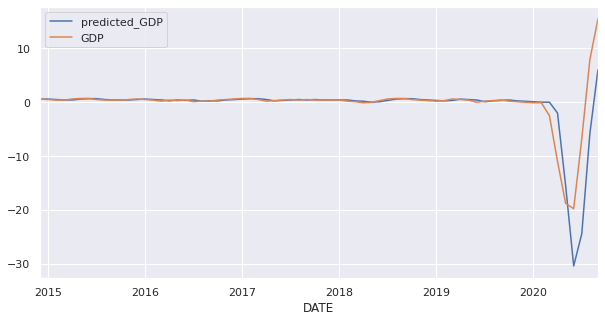

In [91]:
merged_df[["predicted_GDP", "GDP", "DATE"]].set_index("DATE").plot(figsize=(10,5))

In [97]:
# sense check our method
merged_df["manual_rmse"] = abs((merged_df["GDP"] - merged_df["predicted_GDP"])) 
assert all(merged_df["manual_rmse"] == merged_df["test_score"])